# Exercise 11 - Dimensionality Reduction Techniques

The goal of this exercise is to gain insights into the practical use of different dimensionality reduction techniques. These algorithms are useful to explore high-dimensional data such as e.g. scRNA-Seq data, and can help researchers to find patterns in these datasets.

In this exercise we are going to use two different flavours of dimensionality reduction techniques:

* **Linear Dimensionality Reduction**, where we will use principal component analysis (PCA) to find linear structure in our data that explain variance along *orthogonal* axes in the data.

* **Non-Linear Dimensionality Reduction**, where we take a look at t-Distributed Stochastic Neighbour Embedding (t-SNE) and Uniform Manifold Approximation and Projection (UMAP), two algorithms that try to fit complex, non-linear relationships in high-dimensional data in a lower dimensional space (usually in 2D) while trying to preserve the local and global structure in the data. t-SNE and UMAP have been particularly on the rise since the advent of scRNA-Seq and are nowadays found in many publications.


This exercise will focus on a scRNA-Seq dataset from periperhal blood mononuclear cells (PBMCs) from eight lupus patients. The PBMCs of the patients were either left untreated or activated with Interferon Beta for 6h before sequencing.

Reference: Multiplexed droplet single-cell RNA-sequencing using natural genetic variation, Kang et al. 2017. *Nature Biotechnology* https://www.nature.com/articles/nbt.4042




## 0. Setup
### 0.1 Setup - Loading of packages and data

Here, some packages and the files are loaded properly. These files are then brought together so that we have the proper data files for further use. If you are interested, you can check out what happens there.


In [2]:
#@markdown ###0.2 Setup - Data preparations
#@markdown Prepare the environment for the exercise:


#@markdown - Load necessary packages
from scipy.io import mmread
import pandas as pd
!pip install scanpy
import scanpy as sc
import anndata as ad
import numpy as np
from scipy import stats
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import umap
from umap import UMAP
from sklearn.preprocessing import StandardScaler



# read the count matrix
control = sc.read_mtx("GSM2560248_2.1.mtx.gz")
interferon = sc.read_mtx("GSM2560249_2.2.mtx.gz")

# read the barcodes - each barcode corresponds to a single cells
barcodesControl = pd.read_csv('GSM2560248_barcodes.tsv', sep='\t', header=None)
barcodesInterferon = pd.read_csv('GSM2560249_barcodes.tsv', sep='\t', header=None)

# transpose the count matrices (this will change them to cells x genes)
control = control.transpose()
interferon = interferon.transpose()

# read the gene information
genes = pd.read_csv('GSE96583_batch2.genes.tsv', sep='\t', header=None)

# add genes as variable names and make sure the names are unique
control.var_names = genes.iloc[:,1].to_numpy()
interferon.var_names = genes.iloc[:,1].to_numpy()
control.var_names_make_unique()
interferon.var_names_make_unique()

# assign the barcodes as the observation names (i.e. cell names)
control.obs_names = barcodesControl.iloc[:,0].to_numpy()
interferon.obs_names = barcodesInterferon.iloc[:,0].to_numpy()

# add whether or not the cells were stimulated with interferon beta
control.obs["treatment"] = 'control'
interferon.obs["treatment"] = 'interferon'

# create AnnData format - this is a data format used very often in single cell RNA-Seq and some packages provide some utilities to work with this directly
allData = ad.concat({'control':control, 'interferon':interferon}, label="treatment")
allData.obs_names_make_unique()

# read the cell type annotation that was published in the paper - we will use this to look at what they called what cells in this and the next exercise
celltypedata = pd.read_csv('GSE96583_batch2_total_tsne_df.tsv', sep='\t')
celltypedata = pd.concat([allData.obs, celltypedata], axis=1, join="inner")

# some cells are lost - we would have to ask the authors of the paper why that is
cellpresence = []
for idx in range(len(allData.obs_names)):
    cellpresence.append(allData.obs_names[idx] in celltypedata.index)

# but we only keep the ones we find
allData = allData[cellpresence,:]
allData.obs = celltypedata

# in scRNA-Seq especially when doing droplet based scRNA-Seq, cells sometimes fuse together and then they have double the content, here we remove those
idx_singlet = ~allData.obs['multiplets'].str.contains('doublet')
allData_singlets = allData[idx_singlet]

# and then we remove cells with few genes, or genes that are only found in 3 or less cells (one could be more stringent :-))
sc.pp.filter_cells(allData_singlets, min_genes=200)
sc.pp.filter_genes(allData_singlets, min_cells=3)

# we normalise the data and log the counts
sc.pp.normalize_total(allData_singlets, target_sum=1e4)
sc.pp.log1p(allData_singlets)

# just in case, we add the raw data to this AnnData data format too - one never knows if one wants to go back and to sth differently
allData_singlets.raw = allData_singlets

# and then we scale the data, in scanpy, the package we are using here, the standard deviation of a gene >10 gets clipped - in Seurat, a different workflow, this is not done and can lead to differences as pointed out in a recent preprint
sc.pp.scale(allData_singlets, max_value=10)

# for the exercise, at least in this part, we use the gene expression dataframe and the meta data later
# in principle this is not necessary, but we want you to learn PCA, t-SNE and UMAP using common tools and not only scRNA/scanpy specific tools
gene_expression_df = pd.DataFrame(allData_singlets.X, index=allData_singlets.obs_names, columns=allData_singlets.var_names)
meta_df = pd.DataFrame(allData_singlets.obs)






You should consider upgrading via the 'd:\python\env_teaching\scripts\python.exe -m pip install --upgrade pip' command.


d:\Python\env_teaching\lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
d:\Python\env_teaching\lib\site-packages\scanpy\preprocessing\_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


## 1. Linear Dimensionality Reduction
### 1.1 PCA on scRNA-Seq of PBMCs

As introduced above and in the lecture, PCA tries to find linear patterns in the data.

**Question 1:** Are there any obvious linear patterns that you would expect in scRNA-Seq data of stimulated and non-stimulated PBMCs?

**Answer:** The transcriptomes of different cell types should be, at least to some extent, composed of linear patterns, where particular marker genes should separate them from another. Additinoally, the stimulation with interferon beta should further separate treated vs. non-treated cells. However, how strong these effects are on the different cell types is hard to estimate. 


Let's explore this computationally.

In [2]:
# Let's have a look at the data we have - first the cells x genes dataframe
print(gene_expression_df)

                  AL627309.1  RP11-206L10.2  RP11-206L10.9    FAM87B  \
AAACATACATTTCC-1   -0.015197      -0.017456      -0.015198 -0.012306   
AAACATACCAGAAA-1   -0.015197      -0.017456      -0.015198 -0.012306   
AAACATACCATGCA-1   -0.015197      -0.017456      -0.015198 -0.012306   
AAACATACCTCGCT-1   -0.015197      -0.017456      -0.015198 -0.012306   
AAACATACCTGGTA-1   -0.015197      -0.017456      -0.015198 -0.012306   
...                      ...            ...            ...       ...   
TTTGCATGCTAAGC-1   -0.015197      -0.017456      -0.015198 -0.012306   
TTTGCATGGGACGA-1   -0.015197      -0.017456      -0.015198 -0.012306   
TTTGCATGGTGAGG-1   -0.015197      -0.017456      -0.015198 -0.012306   
TTTGCATGGTTTGG-1   -0.015197      -0.017456      -0.015198 -0.012306   
TTTGCATGTCTTAC-1   -0.015197      -0.017456      -0.015198 -0.012306   

                  LINC00115    FAM41C     NOC2L    KLHL17   PLEKHN1  \
AAACATACATTTCC-1  -0.058326 -0.017316 -0.249051 -0.027573 -0.058

In [3]:
# and then the meta data that was provided in the paper
print(meta_df)

                   treatment      tsne1      tsne2   ind  stim  cluster  \
AAACATACATTTCC-1     control -27.640373  14.966629  1016  ctrl        9   
AAACATACCAGAAA-1     control -27.493646  28.924885  1256  ctrl        9   
AAACATACCATGCA-1     control -10.468194  -5.984389  1488  ctrl        3   
AAACATACCTCGCT-1     control -24.367997  20.429285  1256  ctrl        9   
AAACATACCTGGTA-1     control  27.952170  24.159738  1039  ctrl        4   
...                      ...        ...        ...   ...   ...      ...   
TTTGCATGCTAAGC-1  interferon  25.142392   6.603815   107  stim        6   
TTTGCATGGGACGA-1  interferon  14.359657  10.965601  1488  stim        6   
TTTGCATGGTGAGG-1  interferon  27.317997   7.933458  1488  stim        6   
TTTGCATGGTTTGG-1  interferon  13.744084   9.347784  1244  stim        6   
TTTGCATGTCTTAC-1  interferon  14.572118  -4.713942  1016  stim        5   

                             cell multiplets  n_genes  
AAACATACATTTCC-1  CD14+ Monocytes    single

**Remark:** As you can see, the meta data of each cell already tells us a lot about them. The authors labelled each cell according to their treatment, but for the 'cell' column, they actually used the scRNA-Seq data to identify the cell type based on so-called *marker genes*. In this exercise we are going to use this information as given, but of course this could also be generated from the data itself.

Let's move on to PCA now.

In [4]:
# perform PCA
pca = PCA(n_components=100)  # note, that we can decide how many dimensions we want
pca_embedding = pca.fit_transform(gene_expression_df)

By design, the first and second principal components describe most of the variance. Let's visualise how PC1 and PC2 group our cells.

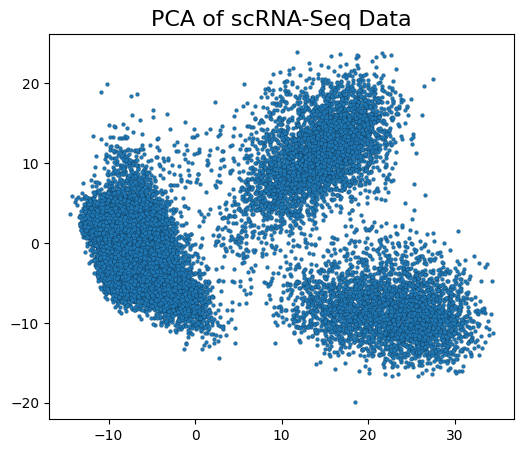

In [5]:
# We can now plot the first two principal components in a scatter plot using a combination of the matplotlib and seaborn packages
plt.figure(figsize=(6, 5))
scatter = sns.scatterplot(x=pca_embedding[:, 0], y=pca_embedding[:, 1],s=8, marker="o", linewidth=0.1, edgecolor='black', alpha=1)
# We can add a title to this
plt.title(f'PCA of scRNA-Seq Data', fontsize=16)
# plot the plot :-)
plt.show()

It seems that PC1 and PC2 group cells into different clusters, but it is also a bit hard to say what that means! We can make use of the meta data the authors of the paper provided.


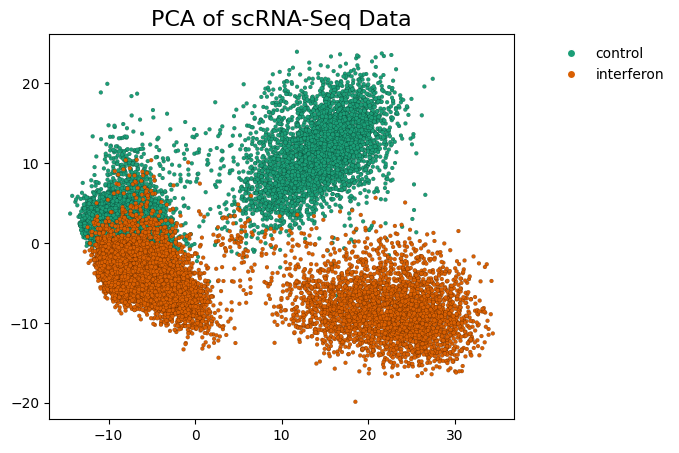

In [6]:
# Let's create a grouping variable to assign colors according to the treatment
class_mapping = {label: idx for idx, label in enumerate(meta_df['treatment'].unique())}

# and now we can map some colours to this grouping
colors = [class_mapping[label] for label in meta_df['treatment']]
color_palette = sns.color_palette('Dark2', n_colors=len(class_mapping))

# We can now plot the first two principal components in a scatter plot using a combination of the matplotlib and seaborn packages
plt.figure(figsize=(6, 5))
scatter = sns.scatterplot(x=pca_embedding[:, 0], y=pca_embedding[:, 1], hue=colors, palette=color_palette,
                          s=8, marker="o", linewidth=0.1, edgecolor='black', alpha=1)

# Let's add a legend so we know which colors correspond to what
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_palette[idx],
                              markersize=6, label=label) for idx, label in enumerate(class_mapping.keys())]

# and then we can add it to the plot
scatter.legend(handles=legend_elements, loc='best', bbox_to_anchor=(1.35, 1), ncol=1, frameon=False)
# We can add a title to this
plt.title(f'PCA of scRNA-Seq Data', fontsize=16)
# plot the plot :-)
plt.show()

**Question 2:** What does this plot show us?

**Answer:** Indeed as postulated regarding Question 1, we can see that the stimulation affects the single-cell transcriptomes of the immune cells. It does seem like it affects some cells more than others though. 


**Task 1:** Visualise the different cell types using PC1 and PC2 and explain what you can see.

Hint: you just need to change the colours.

**Interpretation:** In particular, both types of Monocytes seem to react strongly to the stimulation, at least in the first two orthogonal axes of the data in linear space.

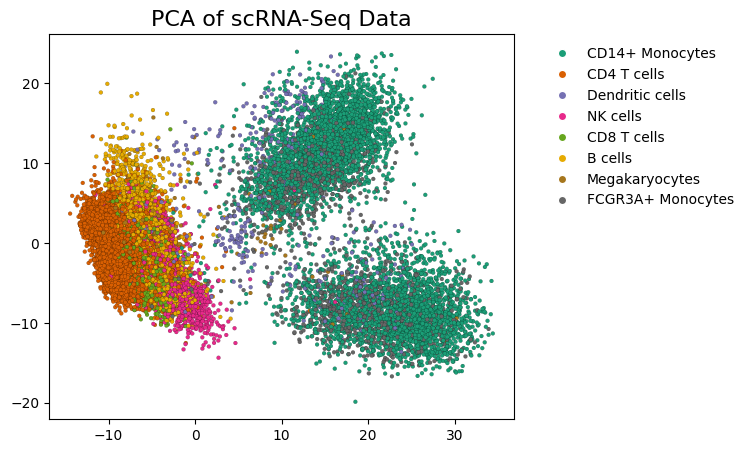

In [7]:
# Let's create a grouping variable to assign colors according to the treatment
class_mapping = {label: idx for idx, label in enumerate(meta_df['cell'].unique())}

# and now we can map some colours to this grouping
colors = [class_mapping[label] for label in meta_df['cell']]
color_palette = sns.color_palette('Dark2', n_colors=len(class_mapping))

# We can now plot the first two principal components in a scatter plot using a combination of the matplotlib and seaborn packages
plt.figure(figsize=(6, 5))
scatter = sns.scatterplot(x=pca_embedding[:, 0], y=pca_embedding[:, 1], hue=colors, palette=color_palette,
                          s=8, marker="o", linewidth=0.1, edgecolor='black', alpha=1)

# Let's add a legend so we know which colors correspond to what
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_palette[idx],
                              markersize=6, label=label) for idx, label in enumerate(class_mapping.keys())]

# and then we can add it to the plot
scatter.legend(handles=legend_elements, loc='best', bbox_to_anchor=(1.5, 1), ncol=1, frameon=False)
# We can add a title to this
plt.title(f'PCA of scRNA-Seq Data', fontsize=16)
# plot the plot :-)
plt.show()

So far we have only looked at the first two principal components, but of course we defined many more above. With the following two plots, we can check, how much of the variance (in percent) can be explained by the different principal components.

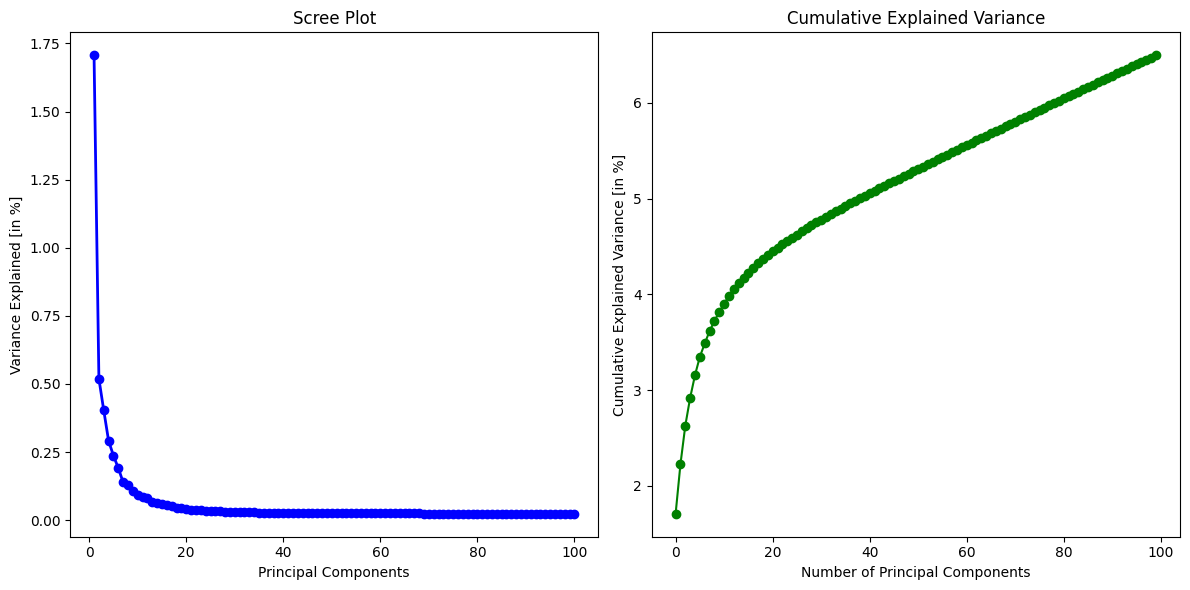

In [8]:
explained_variance_ratio = pca.explained_variance_ratio_

# Scree Plot
plt.figure(figsize=(12, 6))

# First subplot for Scree Plot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio * 100, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained [in %]')

# Second subplot for Cumulative Explained Variance Ratio
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)*100
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(cumulative_variance_ratio, marker='o', color='green')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance [in %]')
plt.title('Cumulative Explained Variance')

# Display the combined figure with both subplots
plt.tight_layout()  # Automatically adjusts subplot params for better layout
plt.show()

**Question 3:** What do these two plots tell you?

**Answer:** The first principal component, as designed in the PCA algorithm indeed explains most of the variance in our data. Across the whole dataset it does seem like the first 100 PCs can only explain around 6-7% of the variance though. Let's keep this in mind for later. 



### 1.2 PCA on CD4+ T-Cells and CD14+ Monocytes

Let's have a look on a smaller subset of the data, what can PCA tell us about healthy CD4+ T-Cells compared to CD14+ Monocytes?


In [9]:
# selection of cell types
idx_cd4_cd14 = meta_df['cell'].isin(['CD4 T cells','CD14+ Monocytes'])

# selection of healthy cells
idx_healthy = (meta_df['treatment'] == 'control')

# Combine conditions using logical AND
selected_cells = idx_cd4_cd14 & idx_healthy

# Subset the gene expression DataFrame
cd4_cd14 = gene_expression_df[selected_cells]

# Subset the metadata DataFrame
meta_cd4_cd14 = meta_df[selected_cells]


In [10]:
# perform PCA on this subset
pca2 = PCA(n_components=100)  # note, just to not overwrite things we change the name here
pca_cd4_cd14 = pca2.fit_transform(cd4_cd14)

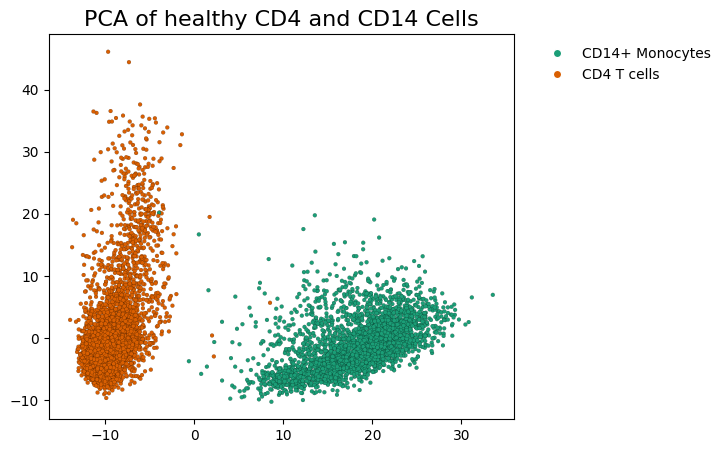

In [11]:
# Let's create a grouping variable to assign colors according to the cell type in the subset
class_mapping = {label: idx for idx, label in enumerate(meta_cd4_cd14['cell'].unique())}

# and now we can map some colours to this grouping
colors = [class_mapping[label] for label in meta_cd4_cd14['cell']]
color_palette = sns.color_palette('Dark2', n_colors=len(class_mapping))

# We can now plot the first two principal components in a scatter plot using a combination of the matplotlib and seaborn packages
plt.figure(figsize=(6, 5))
scatter = sns.scatterplot(x=pca_cd4_cd14[:, 0], y=pca_cd4_cd14[:, 1], hue=colors, palette=color_palette,
                          s=8, marker="o", linewidth=0.1, edgecolor='black', alpha=1)

# Let's add a legend so we know which colors correspond to what
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_palette[idx],
                              markersize=6, label=label) for idx, label in enumerate(class_mapping.keys())]

# and then we can add it to the plot
scatter.legend(handles=legend_elements, loc='best', bbox_to_anchor=(1.45, 1), ncol=1, frameon=False)
# We can add a title to this
plt.title(f'PCA of healthy CD4 and CD14 Cells', fontsize=16)
# plot the plot :-)
plt.show()

This works really well and seems to separate the two cell types!

**Task 2:** Check how much variance the different principal components explain.

Hint: check above!

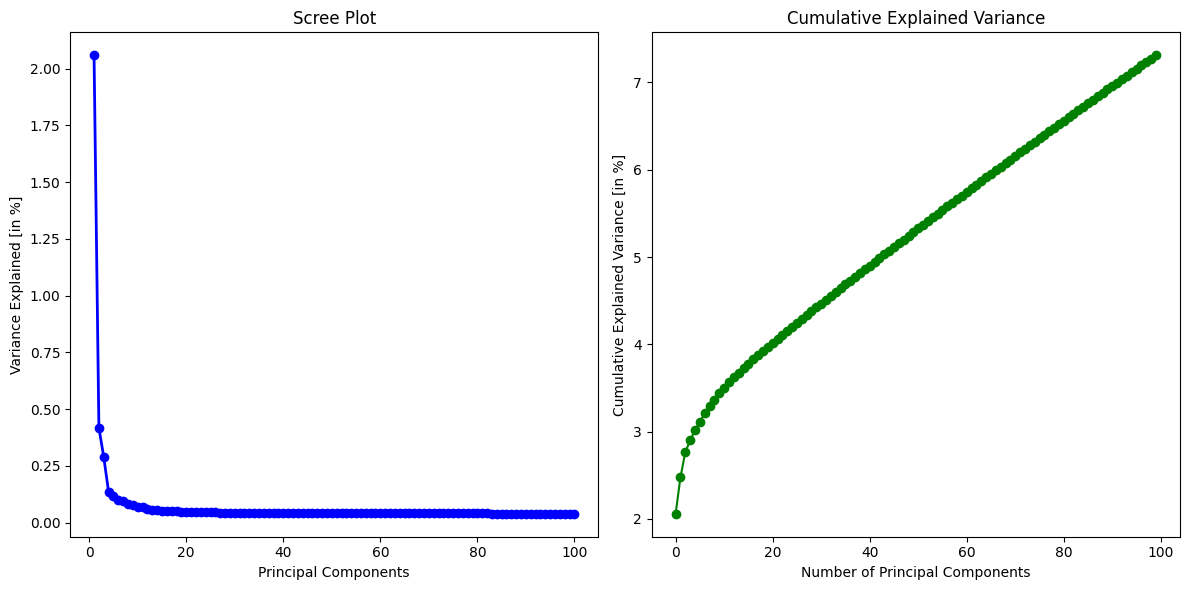

In [12]:
explained_variance_ratio = pca2.explained_variance_ratio_

# Scree Plot
plt.figure(figsize=(12, 6))

# First subplot for Scree Plot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio * 100, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained [in %]')

# Second subplot for Cumulative Explained Variance Ratio
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)*100
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(cumulative_variance_ratio, marker='o', color='green')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance [in %]')
plt.title('Cumulative Explained Variance')

# Display the combined figure with both subplots
plt.tight_layout()  # Automatically adjusts subplot params for better layout
plt.show()

Now, in PCA, the so called *Eigenvalues* represent the variance explained by a particular principal component, and we used them to visualise the percentage of variance explained above. Additionally, there are also the so called *variable loadings or Eigenvectors*, these reflect the weight of each variable on that particular principal component. In our case, this means that we can check the weight of a transcript on a principal component. In simpler terms, we can check which genes drive the separation of our different single cells in the PCA space.

In [13]:
# w can extract the loadings directly from the pca
loadings = pca2.components_.T  # Transpose to align with [genes x components]


In [14]:
# let's create a dataframe of it with the index
loading_df = pd.DataFrame(loadings[:,:2], index=cd4_cd14.columns, columns=['PC1', 'PC2'])

# we can then extract the top 3 and bottom 3 (the most driving genes in either direction) from this dataframe
top_genes_pc1 = loading_df.nlargest(3, 'PC1').index.tolist() + loading_df.nsmallest(3, 'PC1').index.tolist()

# what are these genes?
print(top_genes_pc1)


['IL8', 'S100A8', 'CD14', 'RPS19', 'RPS18', 'MALAT1']


In [15]:
# we can then go back to the actual data and extrat the rna-seq counts
expression_data_pc1 = cd4_cd14[top_genes_pc1]

# and add the cell type info back to this as well
expression_data_pc1['cell'] = meta_cd4_cd14['cell']


C:\Users\ramonp\AppData\Local\Temp\ipykernel_14568\3445631189.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expression_data_pc1['cell'] = meta_cd4_cd14['cell']


Let's visualise the expression data of these genes as violin plots.


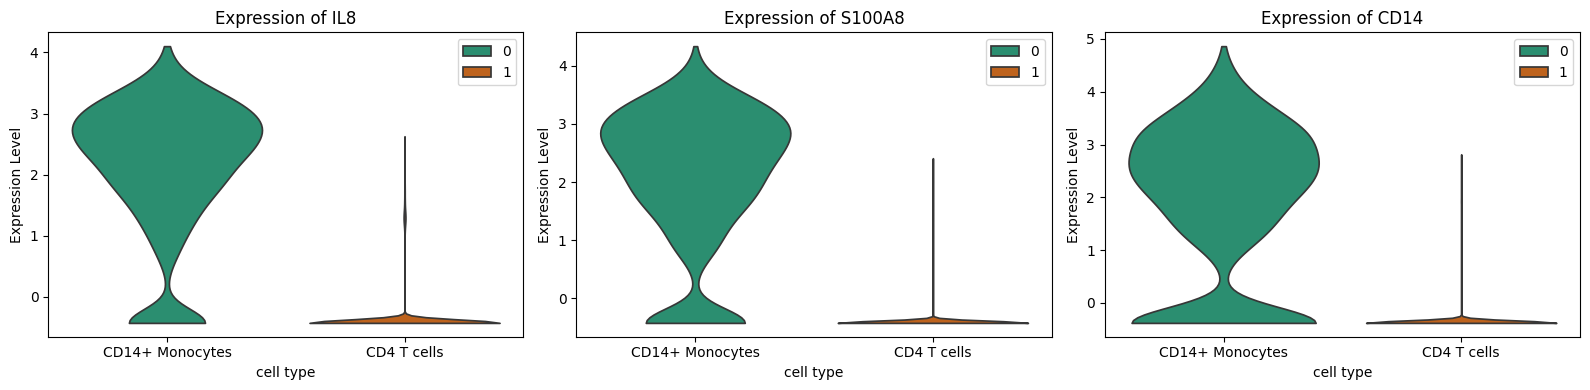

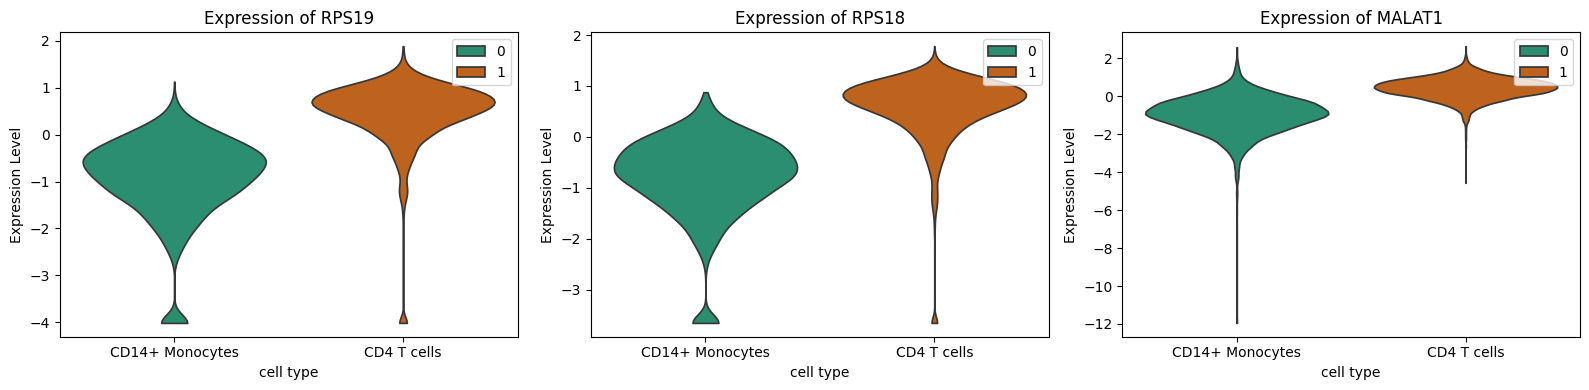

In [16]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
sns.violinplot(data=expression_data_pc1, x='cell', y=expression_data_pc1.columns[0], cut = 0, inner= None, hue=colors, palette=color_palette)
plt.title(f'Expression of {expression_data_pc1.columns[0]}')
plt.ylabel('Expression Level')
plt.xlabel('cell type')


plt.subplot(1,3,2)
sns.violinplot(data=expression_data_pc1, x='cell', y=expression_data_pc1.columns[1], cut = 0, inner= None,hue=colors, palette=color_palette)
plt.title(f'Expression of {expression_data_pc1.columns[1]}')
plt.ylabel('Expression Level')
plt.xlabel('cell type')

plt.subplot(1,3,3)
sns.violinplot(data=expression_data_pc1, x='cell', y=expression_data_pc1.columns[2], cut = 0, inner= None,hue=colors, palette=color_palette)
plt.title(f'Expression of {expression_data_pc1.columns[2]}')
plt.ylabel('Expression Level')
plt.xlabel('cell type')

plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
sns.violinplot(data=expression_data_pc1, x='cell', y=expression_data_pc1.columns[3], cut = 0, inner= None, hue=colors, palette=color_palette)
plt.title(f'Expression of {expression_data_pc1.columns[3]}')
plt.ylabel('Expression Level')
plt.xlabel('cell type')


plt.subplot(1,3,2)
sns.violinplot(data=expression_data_pc1, x='cell', y=expression_data_pc1.columns[4], cut = 0, inner= None,hue=colors, palette=color_palette)
plt.title(f'Expression of {expression_data_pc1.columns[4]}')
plt.ylabel('Expression Level')
plt.xlabel('cell type')

plt.subplot(1,3,3)
sns.violinplot(data=expression_data_pc1, x='cell', y=expression_data_pc1.columns[5], cut = 0, inner= None,hue=colors, palette=color_palette)
plt.title(f'Expression of {expression_data_pc1.columns[5]}')
plt.ylabel('Expression Level')
plt.xlabel('cell type')

plt.tight_layout()
plt.show()

**Question 4:** What are the functions of these genes? Does it make sense that they drive the separation between Monocytes and CD4 T-Cells?

**Answer:** 
- IL-8 and S100A8 are chemokine or chemotactic factors, respectively, and stimulate migration of monocytes to inflammation sites.
- CD14 is a cell surface marker found on, as per their name, CD14+ monocytes.

- RPS19 and RPS18 are ribosomal proteins. Their role in CD4+ T-cells is a bit more complicated but it could be that they are needed for CD4+ T-cells to stimulate their cytokine production.
- MALAT1 is a long non-coding RNA that is implicated in activation of T-cells in general, where it is thought that downregulation leads to activation and differentiation of T-cells. 

**Question 5:** Can you think of additional ways of how you could analyse how these genes relate to these cell types? Hint, think of the previous exercises. 

**Answer:** One could sort the loadings of the transcripts along the respctive principal component axes and perform a gene set enrichment analysis or pick the top X genes to perform a GO term analysis.

**Task 3:** Pick two different cell types and compare them. Explain and interpret your findings.


In [14]:
# selection of cell types
idx_cd8_nk = meta_df['cell'].isin(['CD8 T cells','NK cells'])

# selection of healthy cells
idx_healthy = (meta_df['treatment'] == 'control')

# Combine conditions using logical AND
selected_cells = idx_cd8_nk & idx_healthy

# Subset the gene expression DataFrame
cd8_nk = gene_expression_df[selected_cells]

# Subset the metadata DataFrame
meta_cd8_nk = meta_df[selected_cells]


# perform PCA on this subset
pca2 = PCA(n_components=100)  # note, just to not overwrite things we change the name here
pca_cd8_nk = pca2.fit_transform(cd8_nk)



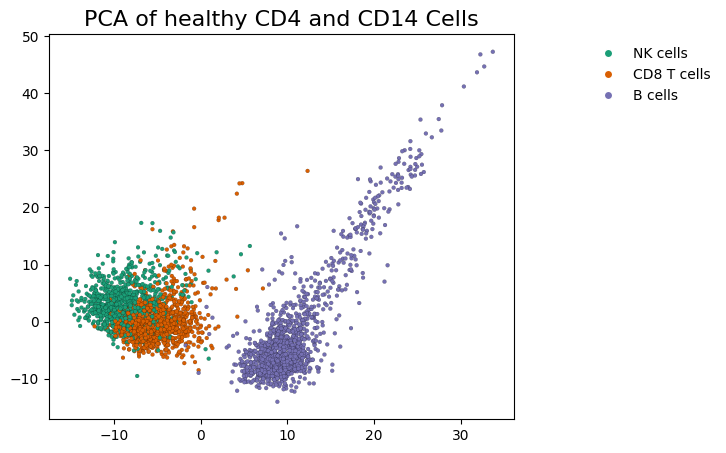

In [15]:
# Let's create a grouping variable to assign colors according to the cell type in the subset
class_mapping = {label: idx for idx, label in enumerate(meta_cd8_nk['cell'].unique())}

# and now we can map some colours to this grouping
colors = [class_mapping[label] for label in meta_cd8_nk['cell']]
color_palette = sns.color_palette('Dark2', n_colors=len(class_mapping))

# We can now plot the first two principal components in a scatter plot using a combination of the matplotlib and seaborn packages
plt.figure(figsize=(6, 5))
scatter = sns.scatterplot(x=pca_cd8_nk[:, 0], y=pca_cd8_nk[:, 1], hue=colors, palette=color_palette,
                          s=8, marker="o", linewidth=0.1, edgecolor='black', alpha=1)

# Let's add a legend so we know which colors correspond to what
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_palette[idx],
                              markersize=6, label=label) for idx, label in enumerate(class_mapping.keys())]

# and then we can add it to the plot
scatter.legend(handles=legend_elements, loc='best', bbox_to_anchor=(1.45, 1), ncol=1, frameon=False)
# We can add a title to this
plt.title(f'PCA of healthy CD4 and CD14 Cells', fontsize=16)
# plot the plot :-)
plt.show()

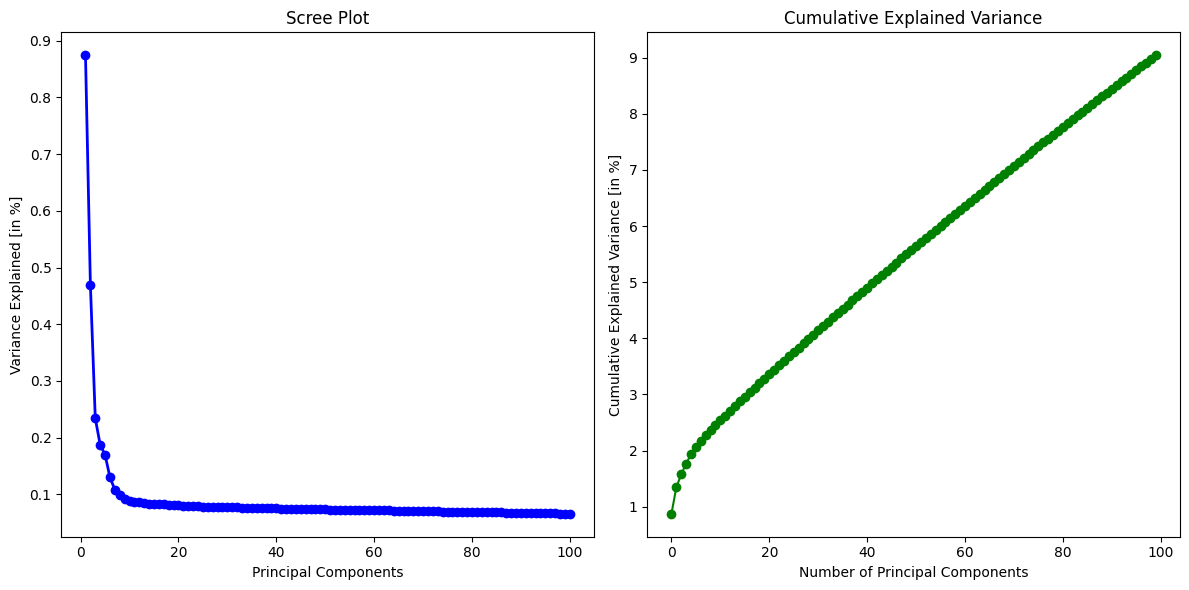

In [16]:
explained_variance_ratio = pca2.explained_variance_ratio_

# Scree Plot
plt.figure(figsize=(12, 6))

# First subplot for Scree Plot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio * 100, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained [in %]')

# Second subplot for Cumulative Explained Variance Ratio
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)*100
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(cumulative_variance_ratio, marker='o', color='green')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance [in %]')
plt.title('Cumulative Explained Variance')

# Display the combined figure with both subplots
plt.tight_layout()  # Automatically adjusts subplot params for better layout
plt.show()

In [21]:
# w can extract the loadings directly from the pca
loadings = pca2.components_.T  # Transpose to align with [genes x components]

# let's create a dataframe of it with the index
loading_df = pd.DataFrame(loadings[:,:2], index=cd8_nk.columns, columns=['PC1', 'PC2'])

# we can then extract the top 3 and bottom 3 (the most driving genes in either direction) from this dataframe
top_genes_pc1 = loading_df.nlargest(3, 'PC1').index.tolist() + loading_df.nsmallest(3, 'PC1').index.tolist()

# what are these genes?
print(top_genes_pc1)

# we can then go back to the actual data and extrat the rna-seq counts
expression_data_pc1 = cd8_nk[top_genes_pc1]

# and add the cell type info back to this as well
expression_data_pc1['cell'] = meta_cd8_nk['cell']



['CD79A', 'MS4A1', 'HLA-DRA', 'NKG7', 'GZMB', 'FGFBP2']


C:\Users\ramonp\AppData\Local\Temp\ipykernel_32176\2938970604.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expression_data_pc1['cell'] = meta_cd8_nk['cell']


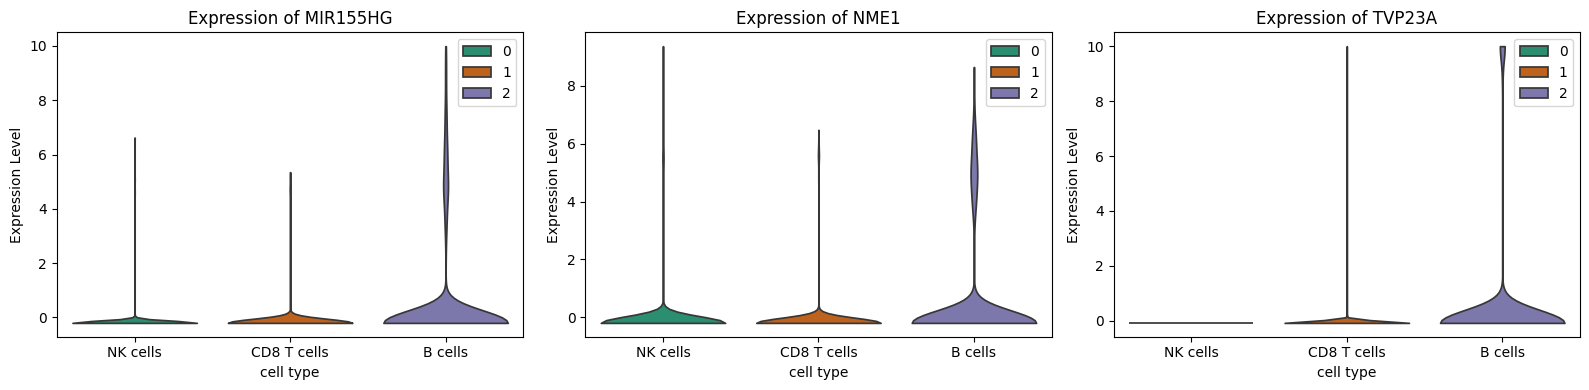

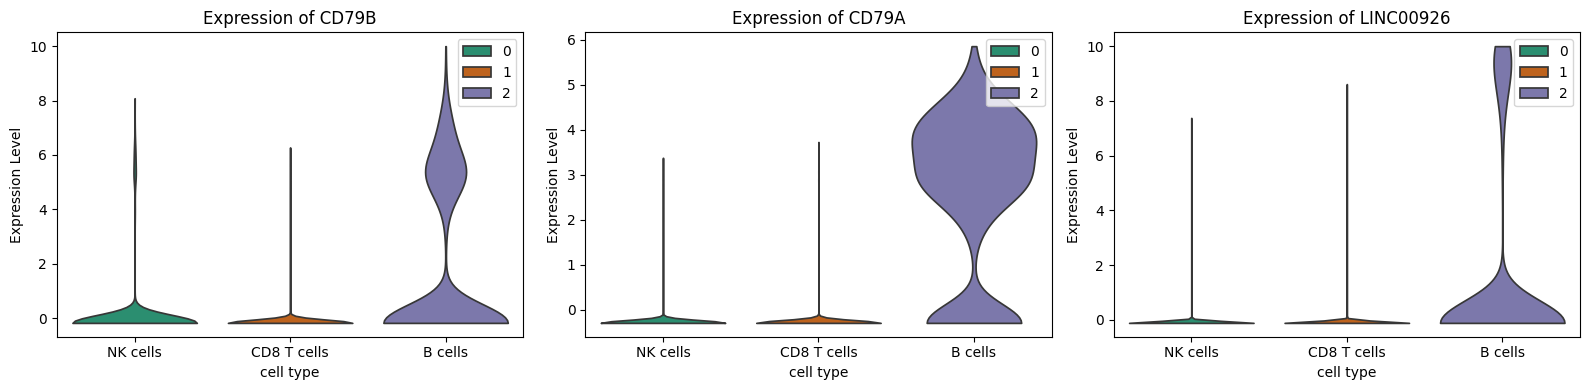

In [20]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
sns.violinplot(data=expression_data_pc1, x='cell', y=expression_data_pc1.columns[0], cut = 0, inner= None, hue=colors, palette=color_palette)
plt.title(f'Expression of {expression_data_pc1.columns[0]}')
plt.ylabel('Expression Level')
plt.xlabel('cell type')


plt.subplot(1,3,2)
sns.violinplot(data=expression_data_pc1, x='cell', y=expression_data_pc1.columns[1], cut = 0, inner= None,hue=colors, palette=color_palette)
plt.title(f'Expression of {expression_data_pc1.columns[1]}')
plt.ylabel('Expression Level')
plt.xlabel('cell type')

plt.subplot(1,3,3)
sns.violinplot(data=expression_data_pc1, x='cell', y=expression_data_pc1.columns[2], cut = 0, inner= None,hue=colors, palette=color_palette)
plt.title(f'Expression of {expression_data_pc1.columns[2]}')
plt.ylabel('Expression Level')
plt.xlabel('cell type')

plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
sns.violinplot(data=expression_data_pc1, x='cell', y=expression_data_pc1.columns[3], cut = 0, inner= None, hue=colors, palette=color_palette)
plt.title(f'Expression of {expression_data_pc1.columns[3]}')
plt.ylabel('Expression Level')
plt.xlabel('cell type')


plt.subplot(1,3,2)
sns.violinplot(data=expression_data_pc1, x='cell', y=expression_data_pc1.columns[4], cut = 0, inner= None,hue=colors, palette=color_palette)
plt.title(f'Expression of {expression_data_pc1.columns[4]}')
plt.ylabel('Expression Level')
plt.xlabel('cell type')

plt.subplot(1,3,3)
sns.violinplot(data=expression_data_pc1, x='cell', y=expression_data_pc1.columns[5], cut = 0, inner= None,hue=colors, palette=color_palette)
plt.title(f'Expression of {expression_data_pc1.columns[5]}')
plt.ylabel('Expression Level')
plt.xlabel('cell type')

plt.tight_layout()
plt.show()

## 2. Non-Linear Dimensionality Reduction

As we saw before, PCA seems to be able to pull bigger effects apart quite well. However, the linear approach seems to not be able to pull apart the differences between the transcriptomes of the different cell types in 2D too well. In this section we are going to look at poplular, in particular in the scRNA-Seq world,
non-linear algorithms which promise to keep both global and local patterns of high-dimensional data intact in lower dimensions. To do this, we are going to use 'scanpy's' inbuilt functions which were specifically designed for scRNA-Seq data. 

### 2.1 t-SNE

Let's first have a look at t-SNE, we can try to recreate Fig. 3A from the paper. 

In [23]:
# at first, we have to give our scanpy input data 'allData_singlets' some numbers for neighbours
# additionally, we actually need PCA here to reduce the super-high-dimensional dataset to fewer dimensions
sc.pp.neighbors(allData_singlets, n_neighbors=10, n_pcs=100)


# this is maybe a bit controvers, and people in the field are activly discussing this. We are going to follow this though, since this is also the standard way it would be explained on scanpy's tutorials. 

ValueError: `X_pca` does not have enough PCs. Rerun `sc.pp.pca` with adjusted `n_comps`.

In [37]:
perplexity_number = 30
sc.tl.tsne(allData_singlets, perplexity=perplexity_number, random_state=42)

We can make use of the inbuilt plotting function here too. In the color brackets you can define that you want to visualise the cell types, or any gene of interest.

In [22]:
sc.pl.tsne(allData_singlets, color = ['cell', 'CD14', 'CD8A', 'HLA-DRA'])

KeyError: "Could not find 'tsne' or 'X_tsne' in .obsm"

**Task 4:** Change the perplexity and see how the t-SNE behave.

**Task 5:** Visualise some of the genes that you found above in the t-SNE, can you see how they previously shaped the PCs in PCA?

## 2.2. UMAP

Let's dive into umap now, we can use the same approach as above and just need to change one line. 

In [39]:
sc.tl.umap(allData_singlets, min_dist=0.1)

Again, we can visualise the cell types and genes of interest as we did before.

d:\Python\env_teaching\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


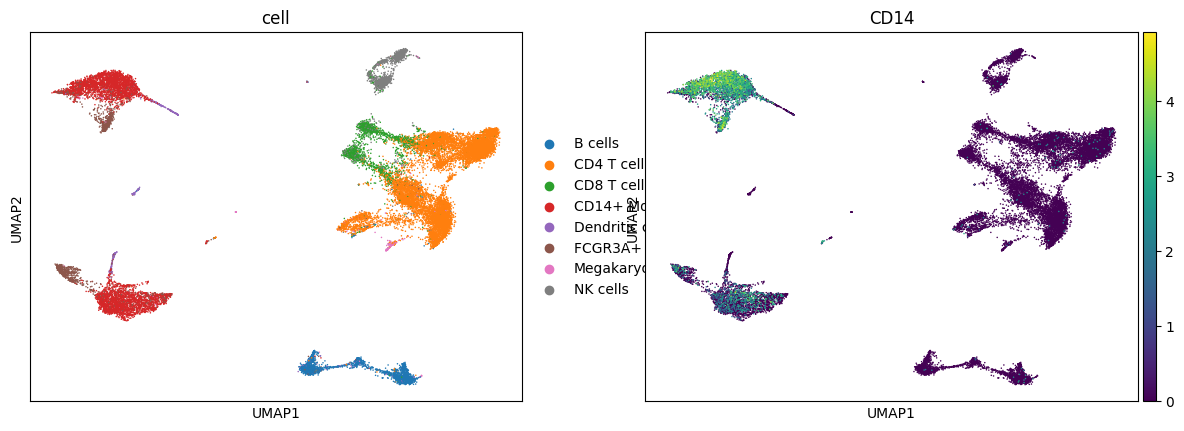

In [40]:
sc.pl.umap(allData_singlets, color=['cell', 'CD14'])

**Task 6:** Change the minimum distance and see how the umap behaves. 
